In [1]:
import os
# Allow duplicate OpenMP runtimes so torch won’t segfault
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print("Set KMP_DUPLICATE_LIB_OK =", os.environ["KMP_DUPLICATE_LIB_OK"])


Set KMP_DUPLICATE_LIB_OK = TRUE


In [16]:
import os, pprint

root = 'dataset/video1'
for sub in ['train/images', 'train/labels', 'valid/images', 'valid/labels', 'test/images']:
    path = os.path.join(root, sub)
    print(path, "→", "EXISTS" if os.path.isdir(path) else "MISSING", "/", 
          len(os.listdir(path)) if os.path.isdir(path) else "")


dataset/video1\train/images → EXISTS / 731
dataset/video1\train/labels → EXISTS / 731
dataset/video1\valid/images → EXISTS / 40
dataset/video1\valid/labels → EXISTS / 40
dataset/video1\test/images → EXISTS / 29


In [8]:
import glob, os

base = 'dataset/video1'
splits = ['train', 'valid', 'test']

for split in splits:
    lbl_dir = f'{base}/{split}/labels'
    for path in glob.glob(os.path.join(lbl_dir, '*.txt')):
        lines = []
        with open(path) as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                # only keep original class 0 (cars) and map it to 2
                # if your old labels never use 1, the others will be discarded
                if parts[0] == '0':
                    parts[0] = '2'
                    lines.append(' '.join(parts))
        # overwrite file with only new '2' lines
        with open(path, 'w') as f:
            f.write('\n'.join(lines))
    print(f'→ Processed {split} labels, {len(glob.glob(lbl_dir+"/*.txt"))} files.')


→ Processed train labels, 1047 files.
→ Processed valid labels, 98 files.
→ Processed test labels, 79 files.


In [9]:
import glob

base       = 'dataset/video1'
splits     = ['train', 'valid', 'test']
errors     = []
unique_ids = set()

for split in splits:
    lbl_dir = f'{base}/{split}/labels'
    for path in glob.glob(f'{lbl_dir}/*.txt'):
        with open(path) as f:
            for lineno, line in enumerate(f, start=1):
                parts = line.strip().split()
                if not parts:
                    continue
                cls_id = parts[0]
                unique_ids.add(cls_id)
                if cls_id != '2':
                    errors.append((path, lineno, line.strip()))

print("✔️  Unique class IDs found in labels:", sorted(unique_ids))
if errors:
    print(f"⚠️  Found {len(errors)} erroneous lines (not class '2'):")
    for p, ln, txt in errors[:5]:
        print(f"   {p}, line {ln}: {txt}")
else:
    print("✅ All labels are class 2 only.")


✔️  Unique class IDs found in labels: ['2']
✅ All labels are class 2 only.


In [18]:
# train_cars_cosine.py
from ultralytics import YOLO
import os

# ─── 1. Paths & run settings ───────────────────────────────────────────────────────────
DATA_YAML   = 'dataset/video1/data.yaml'       # your single-class YAML
PRETRAINED  = 'dataset/yolo11n.pt'            # COCO-pretrained weights
PROJECT     = 'outputs'
RUN_NAME    = 'cars_cosine_run'                # output folder name

# ─── 2. Hyperparameters & schedules ────────────────────────────────────────────────────
EPOCHS        = 100
BATCH_SIZE    = 8
IMGSZ         = 640

OPTIMIZER     = 'AdamW'
LR0           = 0.0005      # initial LR
LRF           = 0.01        # final LR = LR0 * LRF (cosine decay)
WARMUP_EPOCHS = 3

WEIGHT_DECAY   = 0.0005
DROPOUT        = 0.2         # dropout in detection head

LABEL_SMOOTHING = 0.1        # optional

PATIENCE     = 10            # early stopping
DEVICE       = 0             # GPU 0
SINGLE_CLS   = True          # treat your one class as idx=0

# ─── 3. Load model & inject dropout ───────────────────────────────────────────────────
model = YOLO(PRETRAINED)
# inject dropout into YOLOv11n's Detect head
model.model.model[-1].m = DROPOUT

# ─── 4. Train (no augmentations) ──────────────────────────────────────────────────────
model.train(
    data            = DATA_YAML,
    epochs          = EPOCHS,
    batch           = BATCH_SIZE,
    imgsz           = IMGSZ,
    optimizer       = OPTIMIZER,
    lr0             = LR0,
    lrf             = LRF,
    warmup_epochs   = WARMUP_EPOCHS,
    weight_decay    = WEIGHT_DECAY,
    dropout         = DROPOUT,
    label_smoothing = LABEL_SMOOTHING,
    device          = DEVICE,
    patience        = PATIENCE,
    single_cls      = SINGLE_CLS,
    project         = PROJECT,
    name            = RUN_NAME,
    save_period     = 0      # only best.pt & last.pt
)

# ─── 5. Prune extra checkpoints ────────────────────────────────────────────────────────
weights_dir = f"{PROJECT}/{RUN_NAME}/weights"
if os.path.isdir(weights_dir):
    for f in os.listdir(weights_dir):
        if f not in ('best.pt', 'last.pt'):
            os.remove(os.path.join(weights_dir, f))
    print(f"✅ Kept only best.pt & last.pt in {weights_dir}")
else:
    print(f"⚠️  Weights directory not found: {weights_dir}")


WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.156  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/video1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=dataset/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cars_cosine_run2, nbs=64, nms=False, opset=None, optimize=False, 

train: Scanning C:\Users\Himanshu\Desktop\yolov11n\dataset\video1\train\labels... 731 images, 292 backgrounds, 0 corrup

train: New cache created: C:\Users\Himanshu\Desktop\yolov11n\dataset\video1\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 6.31.6 MB/s, size: 74.8 KB)


val: Scanning C:\Users\Himanshu\Desktop\yolov11n\dataset\video1\valid\labels... 40 images, 12 backgrounds, 0 corrupt: 1

val: New cache created: C:\Users\Himanshu\Desktop\yolov11n\dataset\video1\valid\labels.cache


Plotting labels to outputs\cars_cosine_run2\labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to outputs\cars_cosine_run2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.24G      1.433      2.044     0.9895          0        640: 100%|██████████| 92/92 [00:06<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.567      0.773      0.609      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.24G      1.361      1.159     0.9905         10        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.538      0.955      0.708      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.24G      1.237      1.031     0.9358          3        640: 100%|██████████| 92/92 [00:04<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.756      0.775      0.839      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.24G      1.178     0.9135     0.9338          4        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.797      0.818      0.851      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.24G      1.168     0.8986     0.9401          1        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.765      0.886      0.825      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.24G      1.122     0.8414     0.9353          2        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.743      0.818       0.81      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.24G      1.079     0.7966     0.9307         10        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.755      0.841      0.819      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.24G      1.098     0.8201     0.9219          5        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.708      0.795      0.806      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.24G      1.112     0.8174      0.898          8        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.664      0.852      0.786      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.24G       1.08     0.7747     0.8982          0        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0


                   all         40         44      0.814      0.909      0.846      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.24G      1.039     0.7581     0.8828          6        640: 100%|██████████| 92/92 [00:04<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.872      0.926      0.898      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.24G      1.058     0.7692     0.8918          6        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.787      0.922      0.876       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.24G      1.034     0.7143     0.9071          4        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.768      0.841      0.818       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.25G      1.061     0.6912     0.9093         16        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44       0.87      0.909      0.901      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.25G      1.011     0.7139     0.8933          9        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44       0.74      0.864      0.854      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.25G     0.9922     0.6779     0.8801          6        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.845      0.932      0.894      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.25G     0.9524     0.6594     0.8819          3        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.859      0.864      0.909      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.25G      1.018     0.6685     0.8853          1        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.781      0.909      0.844      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.25G     0.9965     0.6569     0.8924          1        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.776      0.866      0.876       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.25G     0.9284     0.6158     0.8808          9        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.834      0.909      0.911      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.25G     0.9268     0.6194      0.881          9        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.788      0.864      0.873      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.25G     0.9391     0.6207     0.8841          6        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.871      0.955      0.928      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.25G     0.9749     0.6294     0.8787          5        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44       0.91      0.922      0.955      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.25G     0.9625     0.6091     0.8825          7        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.853      0.927      0.916      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.25G     0.9256     0.5931     0.8811         10        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.874      0.949      0.921      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.25G      0.915     0.5974       0.87          8        640: 100%|██████████| 92/92 [00:04<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.876      0.932      0.941      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.25G     0.8917     0.5703     0.8692          4        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.825      0.955      0.934      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.25G      0.952     0.6262      0.889          4        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.847      0.886      0.923      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.25G     0.9027     0.5734     0.8586          5        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44       0.92      0.886      0.925      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.25G     0.8965     0.5923     0.8599          6        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.913      0.909      0.952      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.25G     0.8908     0.5683     0.8694          3        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44       0.89      0.918      0.926      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.25G     0.9183     0.5851     0.8688          2        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.784      0.864      0.882      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.25G      0.897     0.5896     0.8587          1        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.837      0.909      0.912      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.25G     0.8668     0.5387     0.8522          3        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.917      0.886      0.934      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.25G     0.8714     0.5421     0.8554          6        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.899      0.909      0.961      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.25G     0.9013     0.5688     0.8549          1        640: 100%|██████████| 92/92 [00:04<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         40         44      0.887      0.889      0.932       0.49
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 26, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



36 epochs completed in 0.051 hours.
Optimizer stripped from outputs\cars_cosine_run2\weights\last.pt, 5.5MB
Optimizer stripped from outputs\cars_cosine_run2\weights\best.pt, 5.5MB

Validating outputs\cars_cosine_run2\weights\best.pt...
Ultralytics 8.3.156  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0


                   all         40         44      0.875      0.932      0.941      0.526
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to outputs\cars_cosine_run2
✅ Kept only best.pt & last.pt in outputs/cars_cosine_run/weights


In [ ]:
outputs/cars_cosine_run2/weights/best.pt


image 1/1 C:\Users\Himanshu\Desktop\yolov11n\dataset\video2\test\images\vid1_mp4-0043_jpg.rf.770459fdc027709484e9124d9e7fbbe4.jpg: 640x640 5 items, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


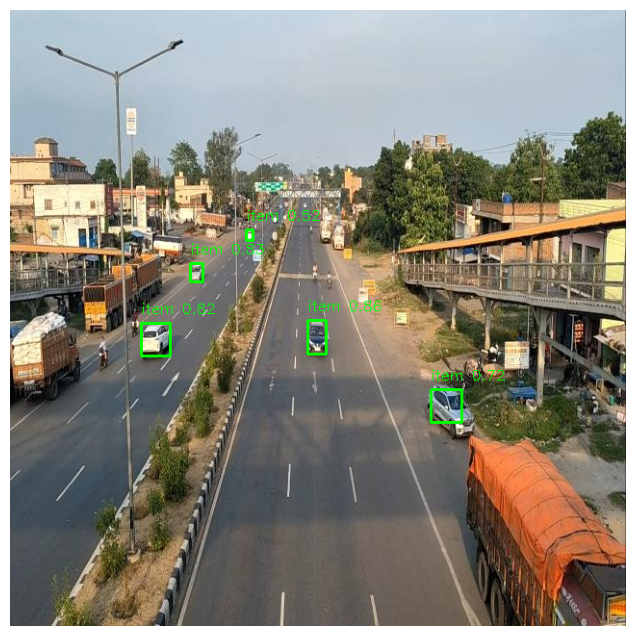

In [27]:
# Make sure figures show up inline in Jupyter
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained model
model = YOLO('outputs/cars_cosine_run2/weights/best.pt')

# Path to your test image
image_path = 'dataset/video2/test/images/vid1_mp4-0043_jpg.rf.770459fdc027709484e9124d9e7fbbe4.jpg'

# Run inference
results = model(image_path, conf=0.3)[0]

# Read image with OpenCV
img = cv2.imread(image_path)

# Draw boxes
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
    cls  = int(box.cls.cpu().numpy().item())
    conf = float(box.conf.cpu().numpy().item())
    label = f"{model.names[cls]} {conf:.2f}"

    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img, label, (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Convert BGR→RGB and display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [23]:
# 1. Run validation on your test partition
res = model.val(
    data='dataset/video1/data.yaml',  # points at train/val/test splits
    split='test',                     # explicitly evaluate on test set
    imgsz=640,                        # same size you trained with
    batch=8,                          # any reasonable batch size
    plots=True                        # generate PR curve & confusion matrix
)


Ultralytics 8.3.156  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 11.19.2 MB/s, size: 77.0 KB)


val: Scanning C:\Users\Himanshu\Desktop\yolov11n\dataset\video1\test\labels... 29 images, 4 backgrounds, 0 corrupt: 100

val: New cache created: C:\Users\Himanshu\Desktop\yolov11n\dataset\video1\test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<0


                   all         29         53      0.862      0.868      0.909      0.547
Speed: 2.5ms preprocess, 7.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val2


In [28]:
import pandas as pd

# After running `res = model.val(...)`, you have:
#  res.box.p        → Precision
#  res.box.r        → Recall
#  res.box.map50    → mAP@0.50
#  res.box.map      → mAP@0.50–0.95
#  res.box.f1       → F1 Score

# Build a table of those values:
metric_names = ['Precision', 'Recall', 'mAP@0.50', 'mAP@0.50:0.95', 'F1 Score']
metric_values = [
    res.box.p,
    res.box.r,
    res.box.map50,
    res.box.map,
    res.box.f1
]

df = pd.DataFrame({'Metric': metric_names, 'Value': metric_values})
display(df)


,Metric,Value
0,Precision,[0.8615012590503939]
1,Recall,[0.8679245283018868]
2,mAP@0.50,0.909008
3,mAP@0.50:0.95,0.547273
4,F1 Score,[0.8647009653273846]


In [40]:
import os
import cv2
import time
import psutil
import torch
import numpy as np
from ultralytics import YOLO
import glob

# ─── Paths & setup ─────────────────────────────────────────────────────────────────────
base_dir        = os.getcwd()
frames_dir      = os.path.join(base_dir, 'FRAMES')
os.makedirs(frames_dir, exist_ok=True)
input_video     = os.path.join(base_dir, 'dataset/test.mp4')
processed_video = os.path.join(base_dir, 'outputs', 'detected_cars.mp4')
compiled_video  = os.path.join(base_dir, 'outputs', 'compiled_video.mp4')
os.makedirs(os.path.dirname(processed_video), exist_ok=True)
os.makedirs(os.path.dirname(compiled_video),  exist_ok=True)

# ─── Model & I/O ───────────────────────────────────────────────────────────────────────
model = YOLO('outputs/cars_cosine_run2/weights/best.pt').half()
cap   = cv2.VideoCapture(input_video)
if not cap.isOpened():
    raise FileNotFoundError(f"Cannot open video {input_video}")
fps = cap.get(cv2.CAP_PROP_FPS) or 20

# ─── Resolution & writer ───────────────────────────────────────────────────────────────
w, h         = 640, 320
fourcc_proc  = cv2.VideoWriter_fourcc(*'mp4v')
out_proc     = cv2.VideoWriter(processed_video, fourcc_proc, fps, (w, h))

# ─── Base line (75% down) ──────────────────────────────────────────────────────────────
line_y = int(h * 0.75)

# ─── CONFIGURABLE LINE PARAMETERS ───────────────────────────────────────────────────────
# RED counting line (entry)
red_y_offset  = 20       # + moves down; - moves up
red_x_start   = 0.55     # fraction of width; ↑ shift right; ↓ shift left
red_x_end     = 0.95     # ↑ lengthens right; ↓ shortens

# BLUE counting line (exit)
blue_y_offset = 0
blue_x_start  = 0.10
blue_x_end    = 0.50

# ─── COMPUTE ACTUAL LINE COORDINATES ────────────────────────────────────────────────────
red_y     = line_y + red_y_offset
red_line  = [
    (int(red_x_start * w), red_y),
    (int(red_x_end   * w), red_y),
]

blue_y    = line_y + blue_y_offset
blue_line = [
    (int(blue_x_start * w), blue_y),
    (int(blue_x_end   * w), blue_y),
]

# ─── Counters & trackers ───────────────────────────────────────────────────────────────
entry_count  = 0
exit_count   = 0
next_id_e    = 0
next_id_x    = 0
e_tracker    = {}  # {id: {'prev':(x,y),'curr':(x,y),'counted':bool}}
x_tracker    = {}
prev_centers = []

# ─── Resource tracking setup ──────────────────────────────────────────────────────────
proc       = psutil.Process(os.getpid())
torch.cuda.reset_peak_memory_stats()
start_time = time.time()
frame_idx  = 0

# ─── Main processing loop ───────────────────────────────────────────────────────────────
while True:
    ret, frame0 = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame0, (w, h))

    # 1) Inference & detection
    res  = model(frame, conf=0.3)[0]
    dets = []
    for box in res.boxes:
        if int(box.cls.cpu()) != 0:
            continue
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        cx, cy         = (x1 + x2)//2, (y1 + y2)//2
        prev           = next(
            (pc for pc in prev_centers if np.hypot(cx-pc[0], cy-pc[1]) < 50),
            None
        )
        dets.append({'box':(x1, y1, x2, y2), 'curr':(cx, cy), 'prev':prev})

    # 2) Entry: assign & count on red_line
    for d in dets:
        cx, cy, pc = *d['curr'], d['prev']
        eid = next(
            (i for i, td in e_tracker.items()
             if np.hypot(cx-td['curr'][0], cy-td['curr'][1]) < 50),
            None
        )
        # assign when crossing red_y upwards
        if eid is None and pc and pc[1] < red_y <= cy:
            eid = next_id_e; next_id_e += 1
            e_tracker[eid] = {'prev':pc, 'curr':(cx, cy), 'counted':False}
        elif eid is not None:
            e_tracker[eid].update(prev=e_tracker[eid]['curr'], curr=(cx, cy))
        # count only once per ID
        if eid is not None:
            td = e_tracker[eid]
            if not td['counted'] and td['prev'][1] < red_y <= td['curr'][1]:
                entry_count += 1
                td['counted'] = True

    # 3) Exit: assign & count on blue_line
    for d in dets:
        cx, cy, pc = *d['curr'], d['prev']
        xid = next(
            (i for i, td in x_tracker.items()
             if np.hypot(cx-td['curr'][0], cy-td['curr'][1]) < 50),
            None
        )
        # assign when crossing blue_y downwards
        if xid is None and pc and pc[1] > blue_y >= cy:
            xid = next_id_x; next_id_x += 1
            x_tracker[xid] = {'prev':pc, 'curr':(cx, cy), 'counted':False}
        elif xid is not None:
            x_tracker[xid].update(prev=x_tracker[xid]['curr'], curr=(cx, cy))
        # count only once per ID
        if xid is not None:
            td = x_tracker[xid]
            if not td['counted'] and td['prev'][1] > blue_y >= td['curr'][1]:
                exit_count += 1
                td['counted'] = True

    # 4) Draw detections & lines
    for d in dets:
        x1, y1, x2, y2 = d['box']
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 1)
    cv2.line(frame, *red_line,  (0,0,255), 2)
    cv2.line(frame, *blue_line, (255,0,0), 2)

    # 5) Overlay stats
    cv2.putText(frame, f"Cars: {len(dets)}",          (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(frame, f"Entry (red): {entry_count}", (10,60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),    2)
    cv2.putText(frame, f"Exit (blue): {exit_count}",  (10,90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0),    2)

    # 6) Save frame & write to video
    cv2.imwrite(os.path.join(frames_dir, f'frame_{frame_idx:05d}.png'), frame)
    out_proc.write(frame)

    prev_centers = [d['curr'] for d in dets]
    frame_idx += 1

# ─── Cleanup & report ─────────────────────────────────────────────────────────────────
cap.release()
out_proc.release()

total_time = time.time() - start_time
avg_fps    = frame_idx / total_time
cpu_pct    = proc.cpu_percent(interval=0.1)
mem_mb     = proc.memory_info().rss / (1024**2)
ram_pct    = psutil.virtual_memory().percent
gpu_peak   = torch.cuda.max_memory_allocated() / (1024**2)

print(f"✅ Processed {frame_idx} frames in {total_time:.1f}s → {avg_fps:.1f} FPS")
print(f"CPU: {cpu_pct:.1f}%   RAM: {mem_mb:.1f}MiB ({ram_pct:.1f}%)   GPU peak: {gpu_peak:.1f}MiB")

# ─── Compile frames into video ──────────────────────────────────────────────────────────
frame_files = sorted(glob.glob(os.path.join(frames_dir, 'frame_*.png')))
fourcc_cmp  = cv2.VideoWriter_fourcc(*'mp4v')
writer_cmp  = cv2.VideoWriter(compiled_video, fourcc_cmp, fps, (w, h))
for f in frame_files:
    img = cv2.imread(f)
    writer_cmp.write(img)
writer_cmp.release()

print(f"🎥 Compiled video saved to: {compiled_video}")



0: 320x640 1 item, 28.9ms
Speed: 1.3ms preprocess, 28.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 item, 24.8ms
Speed: 0.7ms preprocess, 24.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 28.9ms
Speed: 0.6ms preprocess, 28.9ms inference, 0.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 25.9ms
Speed: 0.5ms preprocess, 25.9ms inference, 0.2ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 item, 27.2ms
Speed: 0.5ms preprocess, 27.2ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 item, 32.6ms
Speed: 0.7ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 item, 26.3ms
Speed: 0.5ms preprocess, 26.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 26.6ms
Speed: 0.6ms preprocess, 26.6ms inference, 0.5ms postprocess per image at shap